# Preding wether Forest Pixel is intact or not
Based on Disturbance Index, wether the DI is from a growing season and the forest tpye, these classifiers try to predict wether the pixel is intact or not. Still needed is a labelled dataset

In [27]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

Reading dataset of points randomly scattered across Germany, only keeping those points that have a value for forest type

In [28]:
df = pd.read_csv("data/gcps_sampeld_clipped_latLon.csv")
# clean df of nodata values
df = df.drop(df[df.for_type == 0].index)
df = df.drop(df[df.for_type > 10].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1612 entries, 2 to 4507
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fid       1612 non-null   int64  
 1   id        1612 non-null   int64  
 2   x         1612 non-null   float64
 3   y         1612 non-null   float64
 4   for_type  1612 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 75.6 KB


### Append random values
Sicne there is no labeled data yet, create random entries for DI and growing season

In [29]:
# random array 10<len<20, value between 0.1 and 3.1
def randarray():
    size = 15
    # size = np.random.randint(10,20) # make random size
    arr = np.random.uniform(low=0.1, high=3.1, size=(size,))
    return(np.around(arr, decimals=3))

# randomly return yes or no
def rand_intact():
    a = random.choice([1, 0])
    return(a)
def rand_for():
    a = random.choice(["y", "n"])
    if a == "yes":
        return(1)
    else:
        return(0)

In [30]:
# create list holding random array
# create list holding random y/n for forest & intact
temp_ar = []
temp_forest = []
temp_intact = []
temp_season = []
for i in range(0,len(df)):
    temparray = randarray()
    temp_ar.append(temparray)
    temp_forest.append(rand_for())
    temp_intact.append(rand_intact())
    temp_season.append(rand_intact())

# append random feature lists to DF
df["di"]= temp_ar
df["forest"]= temp_forest
df["intact"]= temp_intact
df["season"]= temp_season

In [ ]:
df_2 = pd.DataFrame({'id' : [],'di' : [],'for_type' : [],'intact' : [],})

# append di's as individual rows
for index, row in df.iterrows():
    temp_di = row["di"]
    for i in temp_di:
        new_row = {'id':int(row['id']), 'di':i, 'for_type':row["for_type"],'season':row["season"], 'intact':row["intact"]}
        df_2 = df_2.append(new_row, ignore_index=True)
# save dataframe to save time
df_2.to_pickle("data/df_2.pkl")

In [31]:
df_2 = pd.read_pickle("data/df_2.pkl")
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24180 entries, 0 to 24179
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        24180 non-null  float64
 1   di        24180 non-null  float64
 2   for_type  24180 non-null  float64
 3   intact    24180 non-null  float64
 4   season    24180 non-null  float64
dtypes: float64(5)
memory usage: 944.7 KB


# Build RF Model
Input features: DI (float), growing season (1/0), forest type (1/0)  
Prediction: intact (yes/no)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# define labels and target
features = df_2[["di","for_type","season"]].to_numpy()
labels = df_2["intact"].to_numpy()

# split data to train and test datasets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.15, random_state = 42)

# create RF model
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth=100)

# fit model
rf.fit(train_features, train_labels)

# predict values
intact_predict = rf.predict(features)

df_2["intact_pred"] = intact_predict

#R2 error
from sklearn.metrics import r2_score
r2 = r2_score(df_2["intact"],df_2["intact_pred"])
print("root mean square error: ",round(r2,2))

root mean square error:  -0.05


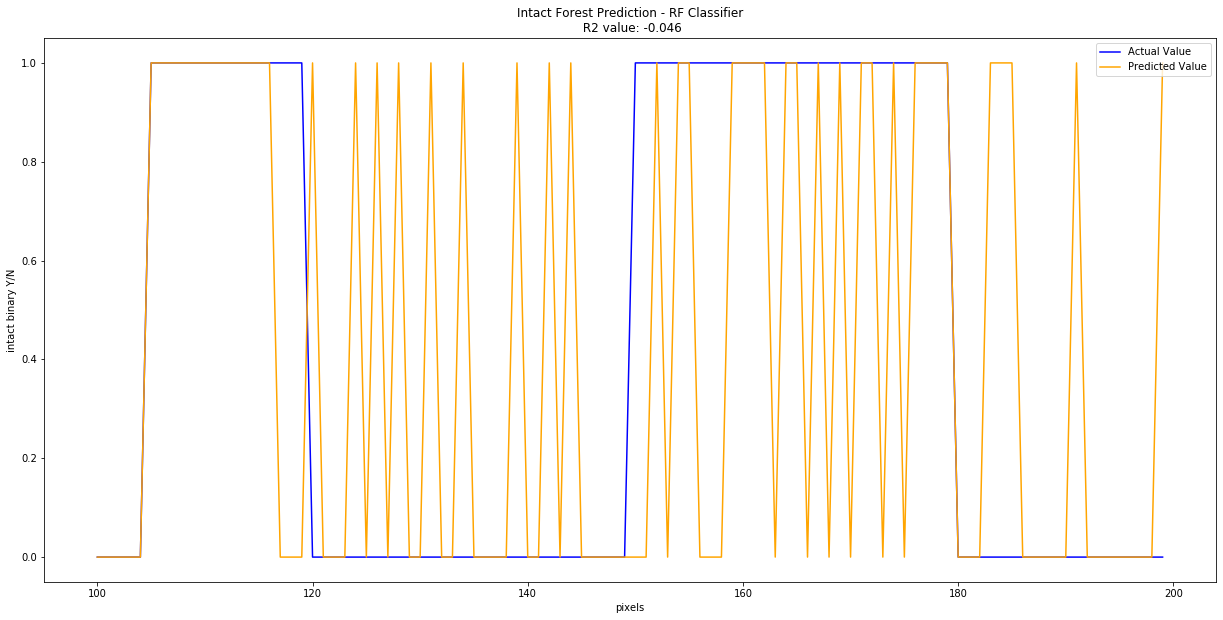

In [33]:
plt.figure(figsize=(21,10))
plt.plot(df_2["intact"][100:200],color="blue")
plt.plot(df_2["intact_pred"][100:200],color="orange")
plt.title("Intact Forest Prediction - RF Classifier\n R2 value: "+str(round(r2,3)))
plt.ylabel("intact binary Y/N")
plt.xlabel("pixels")
plt.legend(["Actual Value", "Predicted Value"], loc='upper right')
plt.show()

## Exporting trained model and saving to file
After the training is done, the model is exported and saved in order to be easily accessible later.

In [34]:
# exporting and saving trained model
import _pickle as cPickle # for saving model
with open("data/rf_model.pkl", 'wb') as file:
    cPickle.dump(rf, file)

# Loading Model and Prediction
This snippet shows how the model can be loaded, also it defines a function that takes a numpy array (1D or 2D) and uses the loaded model to perform the prediction. Note that the inout shape of the array needs to be exactly the same as the shape of the model when it was defined!

In [35]:
# import the following functions to use the code snippet, also adapt the path of the saved model file.
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# import _pickle as cPickle



# loading trained model from file
with open("data/rf_model.pkl", 'rb') as file:
    rf = cPickle.load(file)

# defining function that predicts using model
# takes either single sample or multiple samples as np arrays w/ features DI, season and forest type (in that order)
# Attention: only pass single pixels as tests, only pass 2D arrays for more than a few pixels
def predict_rf(features,rf):
    if features.ndim == 1:
        return(rf.predict(features.reshape(1, -1)))
    else:
        return(rf.predict(features))


## Pass samples to prediction

In [36]:
# pass certain columns of dataframe in right order to prediction
predict_rf(df_2[["di","for_type","season"]].to_numpy(),rf)

# pass single test pixel to prediction
# predict_rf(np.array([0.432,1,1]),rf)

array([0., 0., 0., ..., 1., 1., 0.])

# Build FF-NN Model

In [37]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import keras

In [65]:
def build_model(data_pred,predictors,target,hidden_layer_activation):
    # set predictors
    X = data_pred[predictors]
    # set prediciton goals
    y = data_pred[target]
    # split dataset in training & testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=90)
    
    
    #CNN model definition 
    model = Sequential()
    model.add(keras.Input(shape=(len(predictors),))) # define input shape
    model.add(Dense(1, input_dim=1, activation=hidden_layer_activation, name='input_layer_2' ))
    model.add(Dense(2, activation=hidden_layer_activation, name='1st_hidden_layer' ))
    model.add(Dense(2, activation=hidden_layer_activation, name='2nd_hidden_layer' ))
    model.add(Dense(1, activation='softmax', name='output_layer' ))

    # compile the keras model
    model.compile(loss='mse', optimizer='adam')
    return model,X_train, X_test, y_train, y_test,X,y

predictors_nn = ["di","for_type","season"]
target_nn = ["intact"]
model_nn,X_train_nn, X_test_nn, y_train_nn, y_test_nn,X_nn,y_nn = build_model(df_2,predictors_nn,target_nn,"relu")

# train on models
print("\n\t\tTrain Model")
fitting = model_nn.fit(X_train_nn, y_train_nn, epochs=5, batch_size=10, verbose=1, validation_split=0.2)


		Train Model
Epoch 1/5
1548/1548 [==============================] - 5s 3ms/step - loss: 0.4858 - val_loss: 0.4942
Epoch 2/5
1548/1548 [==============================] - 4s 3ms/step - loss: 0.4858 - val_loss: 0.4942
Epoch 3/5
1548/1548 [==============================] - 5s 3ms/step - loss: 0.4858 - val_loss: 0.4942
Epoch 4/5
1548/1548 [==============================] - 5s 3ms/step - loss: 0.4858 - val_loss: 0.4942
Epoch 5/5
1548/1548 [==============================] - 4s 3ms/step - loss: 0.4858 - val_loss: 0.4942


PLOT FF-NN MMODEL


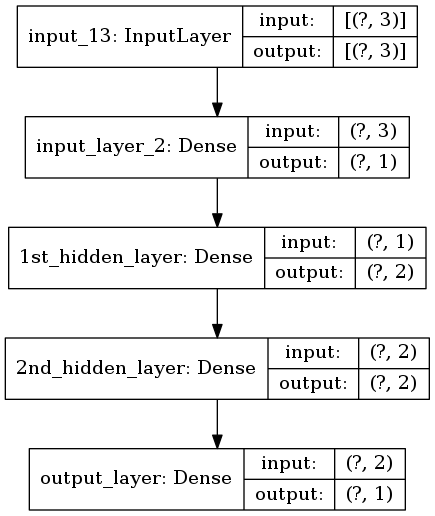

In [66]:
from keras.utils.vis_utils import plot_model
print("PLOT FF-NN MMODEL")
plot_model(model_nn, show_shapes=True, show_layer_names=True)

In [67]:
model_nn.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer_2 (Dense)        (None, 1)                 4         
_________________________________________________________________
1st_hidden_layer (Dense)     (None, 2)                 4         
_________________________________________________________________
2nd_hidden_layer (Dense)     (None, 2)                 6         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 3         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


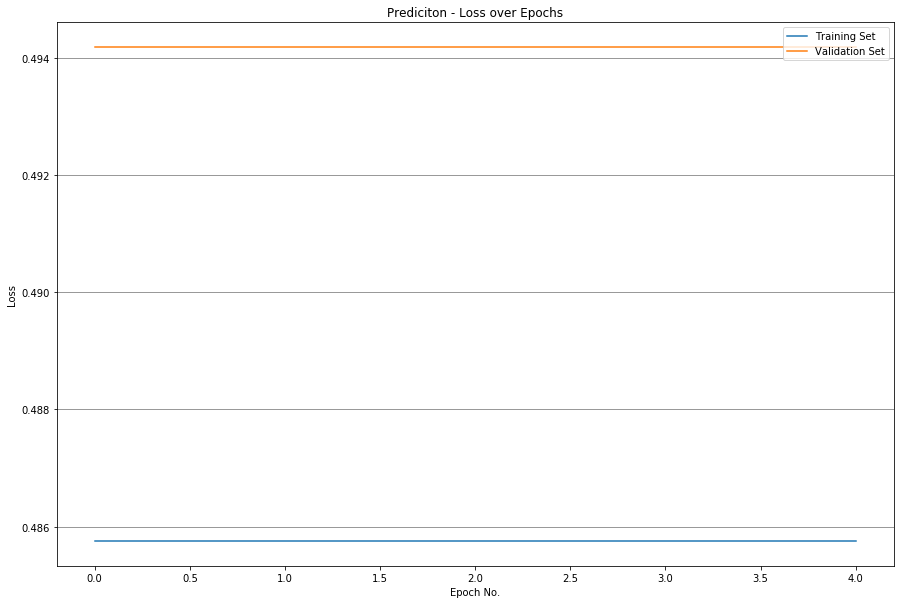

In [68]:
""" Plot Loss Graphs """

plt.figure(figsize=(15,10))
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.title("Prediciton - Loss over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch No.")
plt.grid(color="gray",axis="y")
plt.legend(["Training Set", "Validation Set"], loc='upper right')
plt.show()

In [69]:
scores2 = model_nn.evaluate(X_test_nn, y_test_nn, verbose=0)
print("Accuracy on Training Set: ",round(scores2,3))

Accuracy on Training Set:  0.485


In [70]:
# perform prediction
prediction_nn = model_nn.predict(df_2[["di","for_type","season"]].to_numpy())